In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import folium
import warnings
warnings.filterwarnings("ignore")

In [5]:
lat = -43.25
lon = -74.75
m = folium.Map(location = [lat,lon], zoom_start =10)
folium.Circle(location=[lat,lon],radius=5500,lor='crimson',fill=True,fill_color='crimson').add_to(m)
m.add_child(folium.LatLngPopup())
m

In [106]:
data= np.loadtxt("data/MYD28M2.dat", unpack = True)
fechas = pd.date_range(start='2003-01', end='2022-1',freq = 'M').strftime('%Y-%m')
df = pd.DataFrame({'datetime': fechas , 'data' :data})
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)

<AxesSubplot: title={'center': 'Temperatura Superfical Marina'}, xlabel='Fecha', ylabel='Temperatura(°C)'>

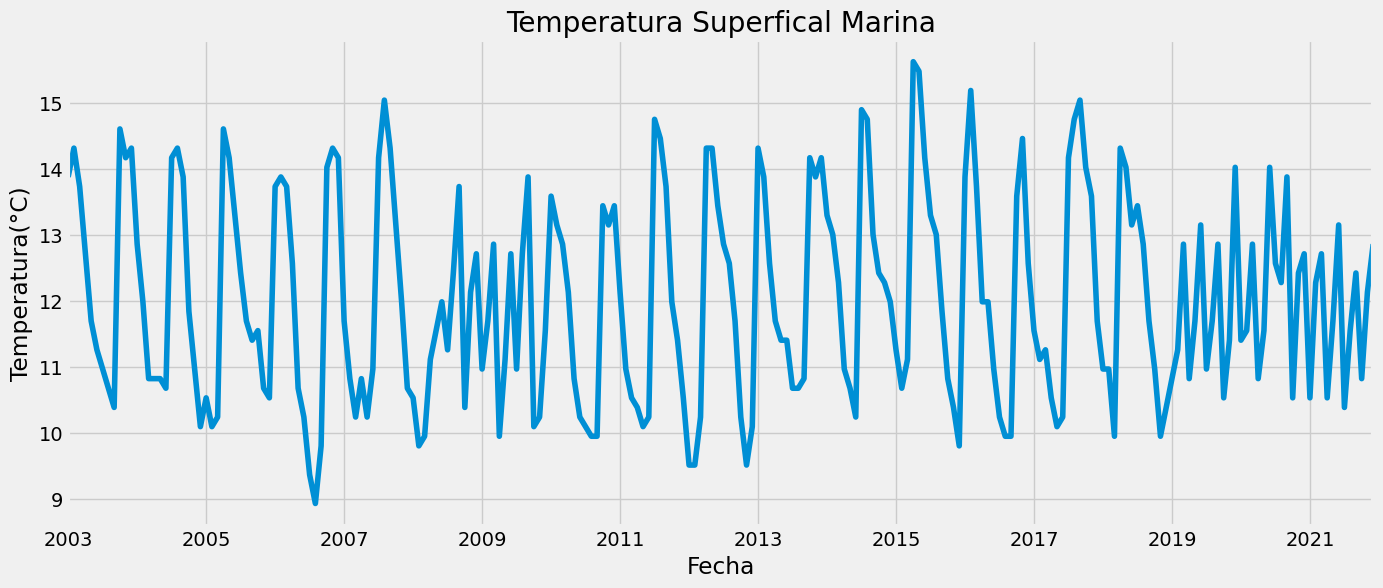

In [107]:
df['data'].plot(legend=False, xlabel='Fecha', ylabel= 'Temperatura(°C)' , title='Temperatura Superfical Marina',
                            figsize=(15,6))

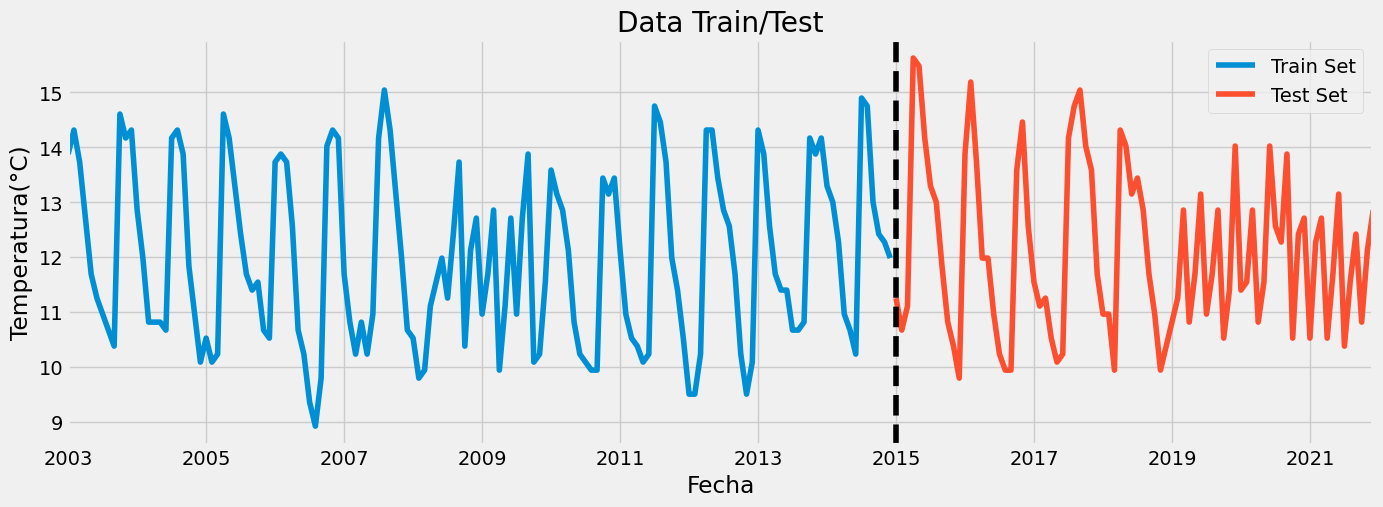

In [108]:

df = df.astype(float)
train = df.loc[df.index < '2015-01']
test = df.loc[df.index >= '2015-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Train Set', title='Data Train/Test')
test.plot(ax=ax, label='Test Set',xlabel='Fecha',ylabel= 'Temperatura(°C)' )
ax.axvline('2015-01', color='black', ls='--')
ax.legend(['Train Set', 'Test Set'])
plt.show()

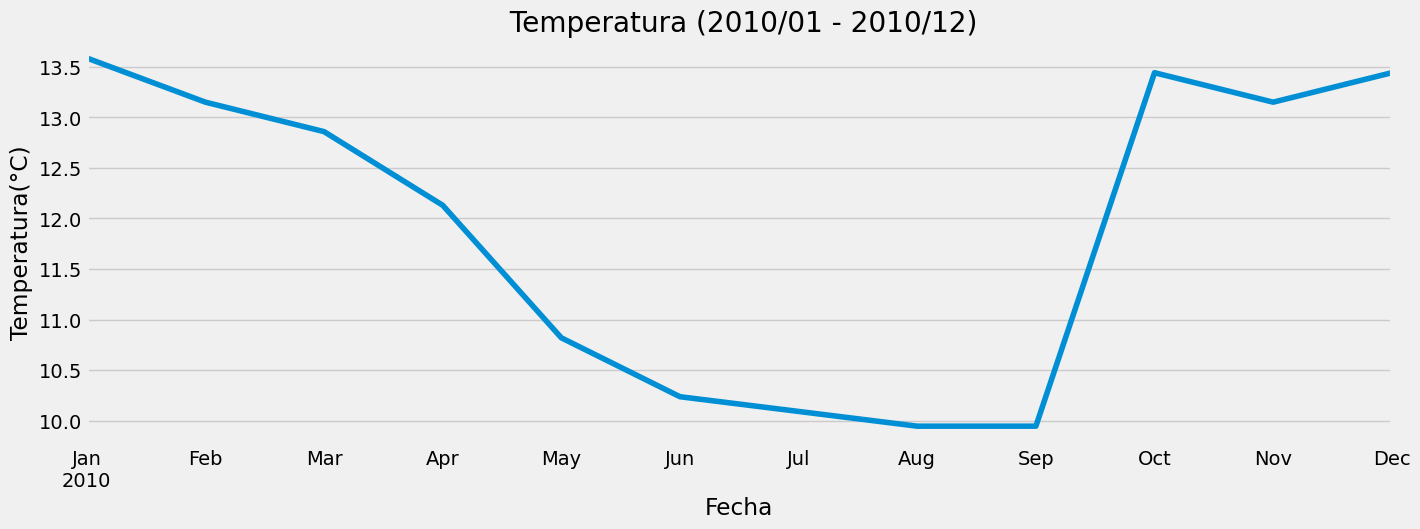

In [109]:
df.loc[(df.index >= '2010-01') & (df.index <= '2010-12')] .plot(legend = False,figsize=(15, 5),xlabel='Fecha',
ylabel= 'Temperatura(°C)',title=' Temperatura (2010/01 - 2010/12)')
plt.show()

In [110]:
def columnas(df):
    df = df.copy()
    df['mes'] = df.index.month
    df['año'] = df.index.year
    return df
df = columnas(df)

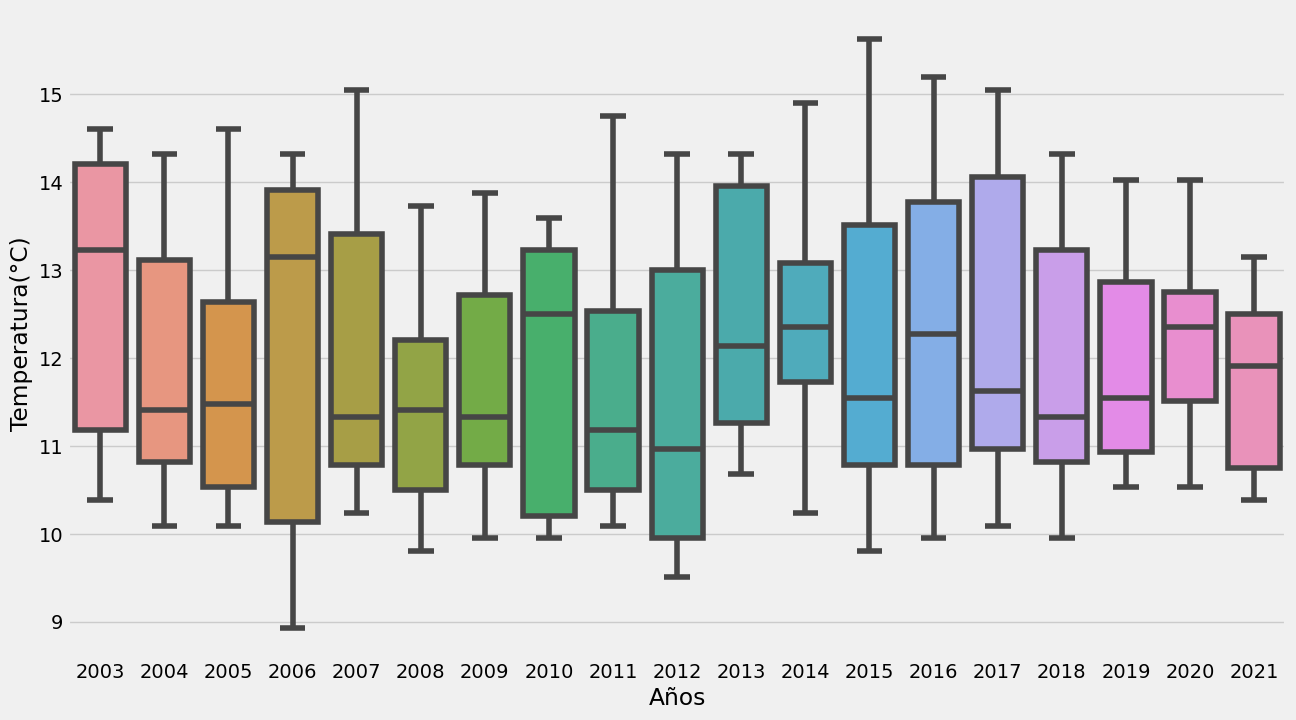

In [111]:
fig, ax = plt.subplots(figsize=(14, 8))
ax = sns.boxplot(data=df, x='año', y='data')
ax.set(ylabel='Temperatura(°C)', xlabel='Años')
plt.show()

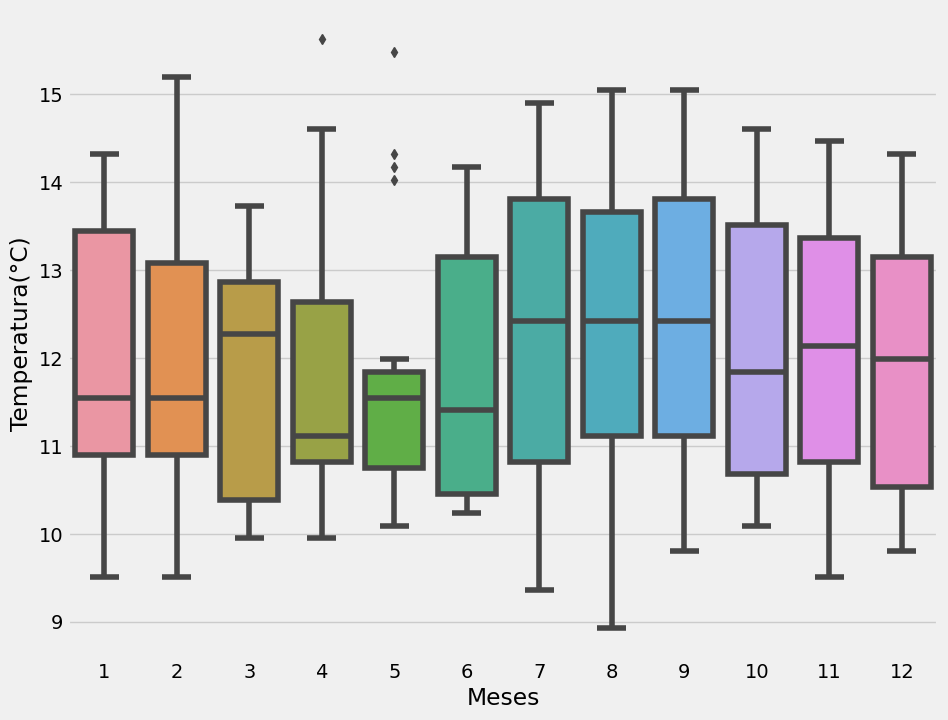

In [112]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.boxplot(data=df, x='mes', y='data')
ax.set(ylabel='Temperatura(°C)', xlabel='Meses')
plt.show()

In [113]:
Train = columnas(train)
Test = columnas(test)

INPUT = ['mes', 'año']
OUTPUT = ['data']

X_train = Train[INPUT]
y_train = Train[OUTPUT]

X_test = Test[INPUT]
y_test = Test[OUTPUT]

In [146]:
reg = xgb.XGBRegressor(n_estimators=100000,learning_rate=0.0001)

In [147]:
reg.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],verbose=10000)

[0]	validation_0-rmse:11.58443	validation_1-rmse:11.69370
[10000]	validation_0-rmse:4.53744	validation_1-rmse:4.62182
[20000]	validation_0-rmse:2.18020	validation_1-rmse:2.19290
[30000]	validation_0-rmse:1.34127	validation_1-rmse:1.74722
[40000]	validation_0-rmse:1.00160	validation_1-rmse:1.83731
[50000]	validation_0-rmse:0.84695	validation_1-rmse:1.87339
[60000]	validation_0-rmse:0.76743	validation_1-rmse:1.92916
[70000]	validation_0-rmse:0.70671	validation_1-rmse:1.95539
[80000]	validation_0-rmse:0.57129	validation_1-rmse:1.97406
[90000]	validation_0-rmse:0.45124	validation_1-rmse:1.98683
[99999]	validation_0-rmse:0.38596	validation_1-rmse:2.01755


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

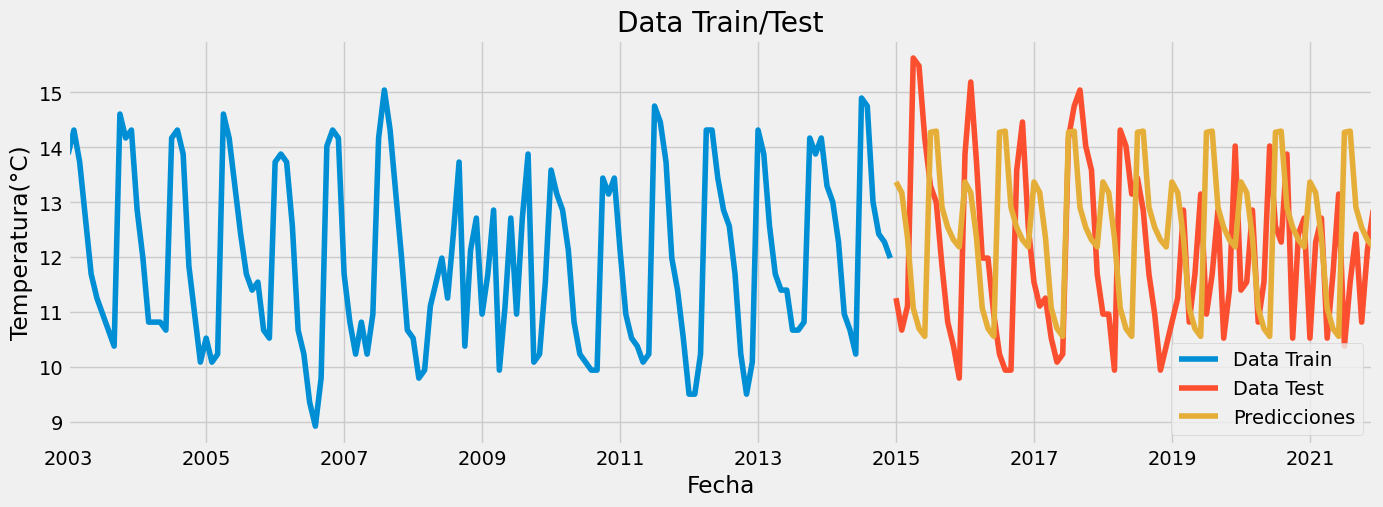

In [161]:

test['predict'] = reg.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 5))
train['data'].plot(ax =ax,title='Data Train/Test')
test['data'].plot(ax=ax)
test['predict'].plot(ax=ax,xlabel='Fecha',ylabel= 'Temperatura(°C)')
plt.legend(['Data Train', 'Data Test','Predicciones'])
plt.show()

In [150]:
score = np.sqrt(mean_squared_error(test['data'], test['predict']))
print(f'Error cuadratico medio: {score:0.2f}')

Error cuadratico medio: 1.64


In [151]:
test['error'] = np.abs(test['data'] - test['predict'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2015-04-01    4.437824
2015-05-01    4.292155
2018-04-01    3.126801
2015-06-01    2.981132
2016-02-01    2.905999
2017-09-01    2.858450
2018-05-01    2.835463
2020-06-01    2.835463
2016-08-01    2.643498
2015-12-01    2.421441
Name: error, dtype: float64

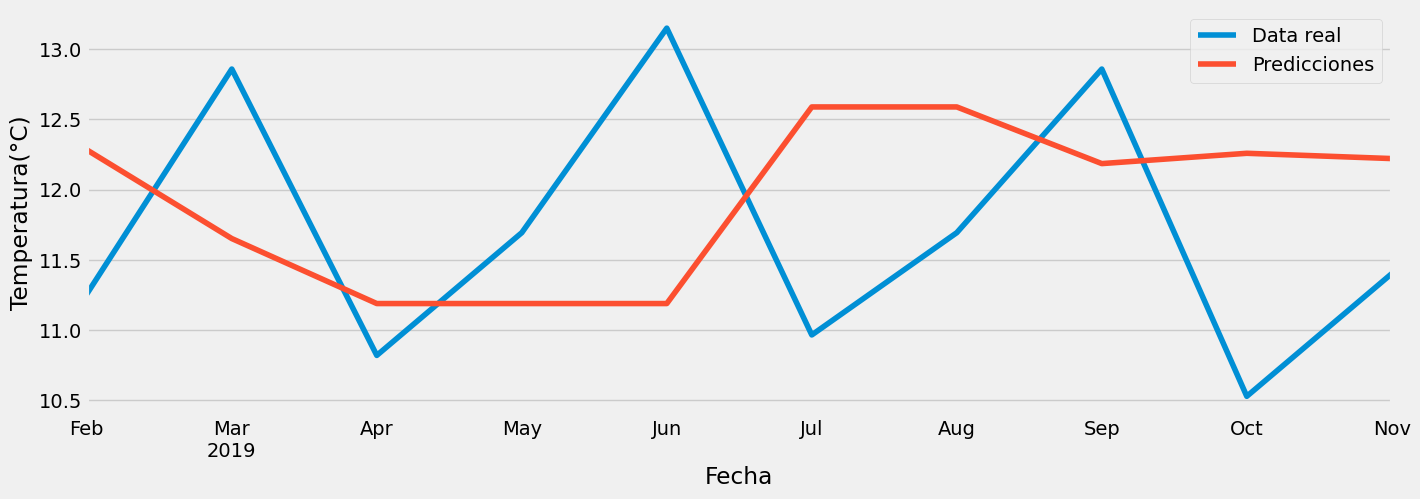

In [152]:
test.loc[(test.index > '2019-01') & (test.index < '2019-12')]['data'].plot(figsize=(15, 5))
test.loc[(test.index > '2019-01') & (test.index < '2019-12')]['predict'].plot(xlabel='Fecha',ylabel='Temperatura(°C)')
plt.legend(['Data real', 'Predicciones'])
plt.show()

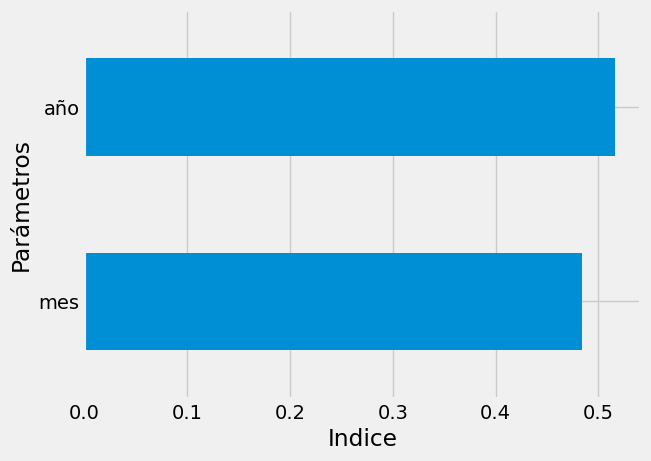

In [153]:
plot = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_,columns=['importancia'])
plot.sort_values('importancia').plot(kind='barh',legend=False,ylabel='Parámetros',xlabel='Indice')
plt.show()